## <u>*Regression Modelling for Frequency as a Target Feature*</u>

In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error,mean_poisson_deviance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import PoissonRegressor

In [32]:
df=pd.read_csv(r"C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/Data_Sets/new_cleaned_df.csv")

In [33]:
df.drop(["clm"],axis=1,inplace=True)

---

*Date preprocessing*

In [34]:
categories_encoder=LabelEncoder()
for col in df:
    if col in list(df.select_dtypes(include="object").columns):
        df[col]=categories_encoder.fit_transform(df[col])

In [35]:
df=df[df["claimcst0"]>0]
df.head()

,veh_value,exposure,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,severity,frequincy,pure_premium
14,1660.0,0.484600,1,669.509999,9,3,1,1,6,670.0,2.063559,1381.573600
16,1510.0,0.993840,1,806.609999,9,3,0,5,4,807.0,1.006198,811.609647
17,760.0,0.539357,1,401.805451,3,3,1,2,4,402.0,1.854061,744.971782
40,1890.0,0.654346,2,1811.709997,10,3,1,5,2,906.0,3.056485,2768.732538
64,4060.0,0.851472,1,5434.439987,10,2,1,5,3,5434.0,1.174437,6382.409020


*Define x and y*

In [36]:
x=df.drop("frequincy",axis=1)
y=df["frequincy"]

*Splitting data into training and testing subsets*

In [37]:
x_train, x_test, y_train, y_test = train_test_split(x,y ,test_size= 0.20)

print("Train data shape of X = % s and Y = % s : "%(
	x_train.shape, y_train.shape))

print("Test data shape of X = % s and Y = % s : "%(
	x_test.shape, y_test.shape))

Train data shape of X = (3699, 11) and Y = (3699,) : 
Test data shape of X = (925, 11) and Y = (925,) : 


*Data Scaling*

In [38]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

In [39]:
params={"alpha":[1,2,3,4,5,6,7,8,9,10],"max_iter":[100,110,120,130]}
model=GridSearchCV(estimator=PoissonRegressor(),param_grid=params)
model.fit(x_train,y_train)

GridSearchCV(estimator=PoissonRegressor(),
             param_grid={'alpha': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_iter': [100, 110, 120, 130]})

In [40]:
model.best_params_

{'alpha': 1, 'max_iter': 100}

In [41]:
glm_freq  = PoissonRegressor(alpha=1, solver="newton-cholesky",fit_intercept=True,max_iter=100)
glm_freq.fit(x_train,y_train)

PoissonRegressor(alpha=1, solver='newton-cholesky')

In [42]:
print("glm_freq.score:", glm_freq.score(x_train,y_train))
print("mean_poisson_deviance:", mean_poisson_deviance(y_test,glm_freq.predict(x_test)))
print("mean_absolute_error :", mean_absolute_error(y_test,glm_freq.predict(x_test)))
print("mean_squared_error :", mean_squared_error(y_test,glm_freq.predict(x_test)))

glm_freq.score: 0.7898175923088495
mean_poisson_deviance: 0.8818185705686111
mean_absolute_error : 1.0518405605603145
mean_squared_error : 20.110919936257236


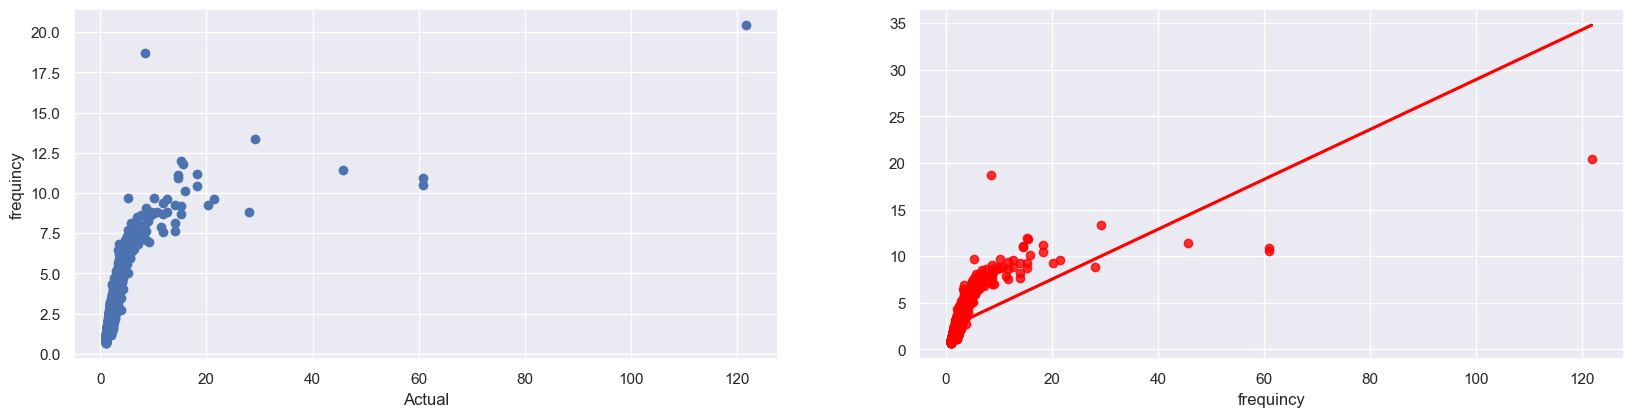

In [43]:
plt.subplot(221)
plt.scatter(y_test,glm_freq.predict(x_test));

plt.xlabel('Actual');
plt.ylabel('frequincy');

plt.subplot(222)
sns.regplot(x=y_test,y=glm_freq.predict(x_test),ci=None,color ='red');

In [44]:
features=df.drop("frequincy",axis=1).columns
model_coef=pd.concat([pd.DataFrame(glm_freq.coef_,columns=["coef"]),pd.DataFrame(features,columns=["features"])],axis=1)
model_coef

,coef,features
0,-0.049242,veh_value
1,-0.675665,exposure
2,0.098021,numclaims
3,0.022093,claimcst0
4,-0.022047,veh_body
5,0.006773,veh_age
6,-0.012424,gender
7,-0.010571,area
8,-0.021927,agecat
9,0.018851,severity


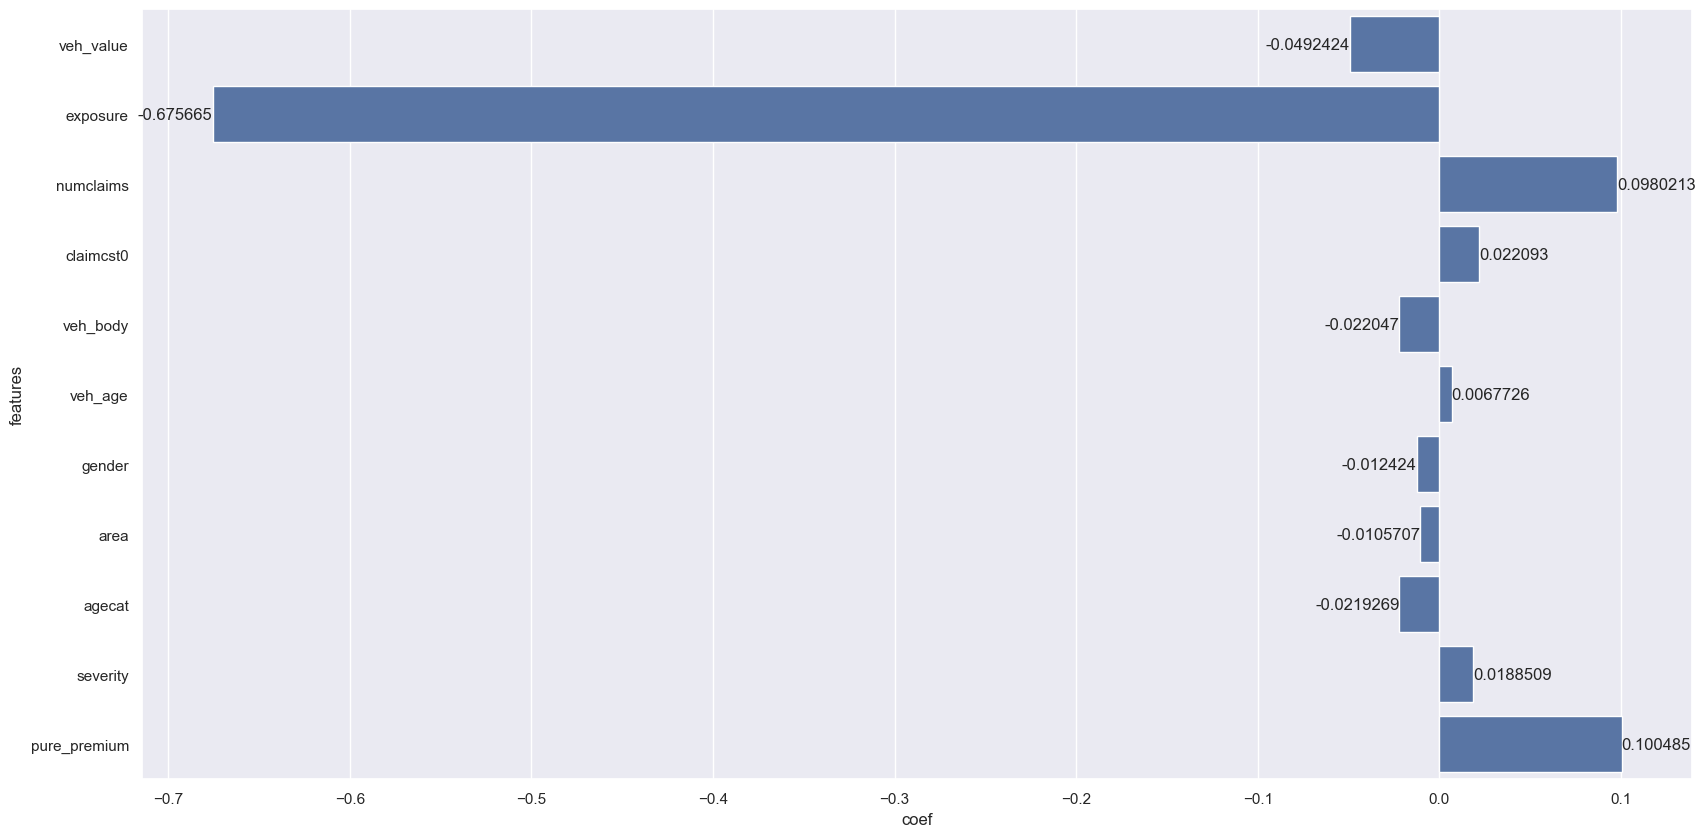

In [45]:
ax =sns.barplot(y='features',x='coef',data=model_coef)
for i in ax.containers:
    ax.bar_label(i,)